# Project 6. Distributed Embeddings and Semi-Supervised Learning #

In this assignment, you will use singular value decomposition (SVD) as well as Word2Vec to learn about lexical semantics. You will have to work with "big" data
- big enough that you will have to think carefully about speed and memory. Of particular importance will **sparse** matrix
representations of your data. For this problem you will be submitting pdf version of ipython with outputs along with original ipython. Some particular functions and classes you might need:

- [scipy.sparse.csr_matrix](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) - matrix in compressed sparse row format
- [scipy.sparse.diags](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html) - method for creating sparse diagonal matrices
- [diagonal()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.diagonal.html) - get the diagonal of a matrix
- [sklearn.preprocessing.normalize](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) - efficiently normalize sparse matrices
- [scipy.sparse.csr_matrix.asfptype()](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.asfptype.html) - upcast matrix to a floating point format
- [scipy.cluster.vq.kmeans2](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans2.html#scipy.cluster.vq.kmeans2) - Classify a set of observations into k clusters using the k-means algorithm
- [numpy.argsort](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html) - returns the indices that would sort an array


In [2]:
%pylab inline
from scipy.sparse.linalg import svds
from scipy.sparse import hstack, diags, csr_matrix
from sklearn.preprocessing import normalize
import numpy as np
import csv
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [3]:
def csv2csr(filename):
    word = []
    context = []
    count = []
    with open(filename,'rb') as infile:
        reader = csv.reader(infile)
        for row in reader:
            word.append(int(row[0]))
            context.append(int(row[1]))
            count.append(int(row[2]))
    return csr_matrix((count,(word,context)))

def readVocab(filename):
    vocab = []
    with open(filename,'rb') as vocabfile:
        for line in vocabfile:
            vocab.append(line.split()[0])
    index = dict(zip(range(0,len(vocab)),vocab)) #from numbers to words
    inv_index = {j:i for i,j in index.items()} #from words to numbers
    return index,inv_index


## 1. Loading the Data ##

Call **C=proj4_starter.csv2csr('doc_trips.csv')** to load a sparse matrix $C$ of a word-document counts. The cell $c[i,j]$ should 
hold the count of word $i$ in document $j$.

Call **idx, iidx=proj4_starter.readVocab('vocab.10k')** to load the vocabulary. You get two **dict** objects, mapping between words 
and indices in the matrix $C$. In **C[iidx['Obama'],:]**, you have the document counts for the word *Obama*.

In [4]:
C = csv2csr('doc_trips.csv')
idx, iidx = readVocab('vocab.10k')
print C.shape

(9993, 1000000)


In [5]:
C

<9993x1000000 sparse matrix of type '<type 'numpy.int64'>'
	with 7733607 stored elements in Compressed Sparse Row format>

## 2. Cosine Similarity ##

The *cosine similarity* of two vectors $u$ and $v$ is defined as 
$$\frac{\sum_{i}u_iv_i}{\sqrt{\sum_iu_i^2\sum_iv_i^2}}$$

** Deliverable 2a** Consider the words *coffee, play, crazy, facebook*, and *hermana* (Spanish for *sister*). For each of them, find the 10 most similar words according to cosine similarity of the rows in $C$. (2 points)

**Hint** The size of the vocabulary is nearly 10,000 words. You do not want to compute and store the entire $10K\times 10K$ matrix 
of cosine similarities. Rather, you want to compute them on demand for a given row of the matrix. You may also want to do some
precomputation to take care of denominator in advance. Whatever you do, don't lose the sparsity of $C$, or you will not be able 
to store it.

**Sanity check** For *facebook*, the top 5 words I get are *facebook page on twitter deleted instagram*

In [6]:
# Here is the word list
word_list = ['coffee','play','crazy','facebook','hermana']

In [7]:
def normalizeRow(x):
    '''
    Normalize each row of x
    '''
    return diags(np.array(1./(1e-6+np.sqrt(x.multiply(x).sum(axis=1))))[:,0],0) * x

def computeCosSimPerWord(word_idx, x):
    '''
    For a given data matrix, compute cosine similarity between the word with index "word_index" and all words 
    (including itsself)
    
    Should return a 1-D np.array, not a matrix.
    '''
    # x should be normalizedC below
    return x.dot(x[word_idx,:].T).toarray()[:,0]

In [8]:
normalizedC = normalizeRow(C)

printSimilarWords  is used to print the top 10 similar words to a given word

In [9]:
def printSimilarWords(x, word_list, sim_func, vocab=idx, ivocab=iidx):
    for word in word_list:
        print word, ':', 
        word_idx = ivocab[word]
        sim_idx = np.argsort(-sim_func(word_idx, x))[:10]
        for word2_idx in sim_idx:
            print vocab[word2_idx],
        print ''

In [10]:
printSimilarWords(normalizedC, word_list, sim_func=computeCosSimPerWord)

coffee : coffee mug shop starbucks drinking drink cup cups and large 
play : play to games game the and with soccer i . 
crazy : crazy 's how that it shit is drives i . 
facebook : facebook page on twitter deleted instagram status compra post whatsapp 
hermana : hermana mi concha la y de tu con regalo que 


** Deliverable 2b ** Come up with five words of your own that you think might be interesting, and list the top 10 most similar for each. Try to choose a few different types of words, such as verbs, adjectives, names, emotions, abbreviations, or alternative spellings. (1 point)

In [11]:
additional_word_list = ['computer', 'google', 'science', 'math', 'physics']

In [12]:
printSimilarWords(normalizedC, additional_word_list, sim_func=computeCosSimPerWord)

computer : computer lab my screen transfer gates staring virus science on 
google : google search image compra global searching autocorrect youtube according facebook 
science : science maths physical earth rocket computer english math study balance 
math : math homework teacher class test problems study exam solve subject 
physics : physics maths lab tests further subject assignment reaction british kanina 


## 3. Document Co-occurence ##

Compute the document co-occurence matrix $D$, where $d_{i,j}$ is the probability $P(w_j|w_i)$ that word $j$ appears in a tweet, 
given that word $i$ appears. To do this, first compute the co-occurence counts $CC^\top$. Substract the diagonal, then normalize 
each row. 

Note: it is possible to smooth this probability, but if you naively add some number to the matrix, you will lose sparsity 
and memory will blow up. You can do it unsmoothed. However, smoothing is not required here.

** Deliverable 3** For each of the 10 examples above (my five words and your five words), find the 10 most similar words according to cosine similarity of the rows of $D$. (2 points)

**Sanity check** For *facebook*, the 5 words I get are *facebook instagram twitter tv youtube*

In [13]:
def computeCooccurMatrix(C):
    '''
    Compute the co-occurence matrix D
    '''
    D = C.dot(C.T)
    D = D - diags(D.diagonal(),0)
    '''
    coeff_norms = np.array(np.sqrt(C.multiply(C).sum(axis=1)))[:,0]
    for i in range(D.nnz):
        print i
        row = D.nonzero()[0][i]
        col = D.nonzero()[1][i]
        coeff = np.sqrt(coeff_norms[row]*coeff_norms[col])
        D[row,col] = D[row,col]/coeff
    '''
    return D

D = computeCooccurMatrix(C)
normalizedD = normalizeRow(D)

In [14]:
word_list = word_list + additional_word_list

In [15]:
printSimilarWords(normalizedD, word_list, sim_func=computeCosSimPerWord)

coffee : coffee new today drinking getting food after day eating water 
play : play down be back pass show beat them up run 
crazy : crazy weird sad not stupid damn actually cool about over 
facebook : facebook instagram twitter tv youtube tumblr 100 note ex insta 
hermana : hermana abuela hermano vieja novio novia viejo padre familia corazon 
computer : computer phone mind body family own arm head cat husband 
google : google online okay true 100% super alright wow very oh 
science : science free record red gold new big form line football 
math : math seriously lost today exam damn completely literally test paper 
physics : physics new after book dance test kid with time today 


## 4. Latent Semantic Analysis ##

Perform truncated SVD (**scipy.sparse.linalg.svds**) to obtain $USV^\top\approx C$ using $K=10$. Each row vector $u_i$
is a description of the word $i$. You can compute similarity between pairs of words using the squared Euclidean norm 
$\|u_i-u_j\|^2_2$.

** Deliverable 4(a)** For each of the 10 examples above, find the 10 most similar words according to squared Euclidean distance in $U$. (3 points)

**Sanity check** For *facebook*, the top 5 words are *facebook ex harry calls snap *

In [16]:
def computeEuclidDist(word_idx, U,with_S = False):
    '''
    Compute the Euclid distance bwteen word with index "word_idx" and all words 
    (including itself)
    
    Args:
      word_idx - the word index
      U - latent representation of words
    Return:
        Euclidean distance from representation of word_idx to all words
    '''
    dis = np.sum((U - U[word_idx,:])**2,axis=1)
    return dis

In [17]:
'''
Once you finish the function computeEuclidDist, run the following code directly to print results
'''
Cfp= C.asfptype()
U = svds(Cfp, 10)[0]

In [18]:
printSimilarWords(U, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee drinking paper cat eating apparently turned short dress months 
play : play looking everyone anyone another start coming use enough away 
crazy : crazy gone stupid sad cool yet funny perfect must once 
facebook : facebook ex harry calls snap instagram ...... uh 18 fav 
hermana : hermana unas minutos colegio toca novia verte gana juego unos 
computer : computer productive tie swim paint cancer adult reaction wide dry 
google : google adam mrs download ryan nick hero speaking haters cash 
science : science wood silver chapter range political wing rate injured setting 
math : math emotional stayed annoyed glasses stopped throat oops studying grew 
physics : physics blunts nine washed beyonce rolled pounds dip 1% shoulders 


** Deliverable 4(b) ** Now compute the same SVD with $K=50$, and again find the 10 most similar words according to Euclidean distance $U$. (1 point)

In [19]:
# your code here
U = svds(Cfp,50)[0]

In [20]:
printSimilarWords(U, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee tea wine four gas midnight starbucks service wedding six 
play : play hang run chill we're agree nobody kids fight games 
crazy : crazy weird stupid actually af dumb serious dead ugly dude 
facebook : facebook instagram focus ig netflix earth floor fb tl list 
hermana : hermana sonrisa llevo plata jajajaj realidad arriba jajaj vuelta novia 
computer : computer forehead ankle toe toes battery shoulder shoulders plate whilst 
google : google dvd flappy drawing bbc gd spin vid mobile replay 
science : science indian silver ukraine agent ops 140 bjp alabama oklahoma 
math : math research chemistry physics doo frozen tech lab appointment ...? 
physics : physics pong bd mesaj 150 cricket ahahahaha smfh tfios lawrence 


** Deliverable 4(c) ** Now compute the SVD of the matrix $\mathbf{D}$, using with $K = 10$, and $K = 50$. Report 
the most similar words to each of the example words according to Euclidean distance in $U$. (1 point)

In [21]:
# your code here for K = 10
Dfp = normalizedD.asfptype()
U = svds(Dfp, 10)[0]
printSimilarWords(U, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee paper complete chinese turning workout ordered hour perfectly cutting 
play : play animals order fill hyped they halfway out speaking happening 
crazy : crazy still worked checked yesterday started more might opinion surprised 
facebook : facebook anime gossip 10x ex chocolate lips loose calls flappy 
hermana : hermana cualquier huevo abuela #buenasnoches poco las mis durmiendo vueltas 
computer : computer daughter break certain growing yogurt husband eating shift belly 
google : google online jackie super ab goo abs facts safe 9:30 
science : science red utd silver bill stretch runs walker landed indian 
math : math typing timeline fml starving glasses addiction ink ruined ruin 
physics : physics teacher blunts beyonce bone sex #smh finding sunburn closet 


In [22]:
# your code here for K = 50
Dfp = normalizedD.asfptype()
U = svds(Dfp, 50)[0]
printSimilarWords(U, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee tea six food night today half sugar new miles 
play : play pass run i'm win beat other him back be 
crazy : crazy nasty cool funny lame true fast pretty scary not 
facebook : facebook instagram twitter ig youtube netflix focus based tv tumblr 
hermana : hermana novia abuela vieja hermano reina sonrisa familia padre amiga 
computer : computer laptop phone screen account arm leg shoulder license ankle 
google : google 100% reading 100 online ok too correct about an 
science : science david paul code football an health challenge christ career 
math : math exam literally english lost now test essay seriously today 
physics : physics nine new bell soccer basketball writing disney rose gaga 


In [23]:
# optionally, try K = 100 and see if it's even better
Dfp = normalizedD.asfptype()
U = svds(Dfp, 100)[0]
printSimilarWords(U, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee tea food pizza drink new half green ice all 
play : play be run beat win start down up drive come 
crazy : crazy actually about dude scary cool not too legit pretty 
facebook : facebook twitter instagram tv youtube tumblr ig social focus based 
hermana : hermana hermano abuela vieja novio reina padre favorito novia corazon 
computer : computer phone screen laptop flight arm account toe list ankle 
google : google an ok too show as haha 100 lol now 
science : science water new an code joe challenge meat american free 
math : math now test chemistry period study literally all apparently lost 
physics : physics math gas now actually bell green near basketball new 


## 5. Local Context ##

Local context captures the frequency with which words appear in each others’ immediate context. We have provided a CSV file (succ_trips_50k.csv)  in which each line contains a triple $\langle x,y,z\rangle$, 
where $x$ and $y$ are term IDs and $z$ is the count of times where $y$ immediately follows $x$ . 
The vocabulary has now increased to 50K words. There is an associated vocabulary file, **vocab.50k**.

**Deliverable 5a **
Build a sparse matrix $\mathbf{E}$ from these triples. Normalize the rows of $\mathbf{E}$, such that $e_{i,j}=\frac{n(i,j)}{n(i)}$, the probability of seeing word $j$ given that you have just seen word $i$. 
Now form a matrix $\mathbf{F} = [\mathbf{E}~ \mathbf{E}’]$ by horizontally concatenating the normalized matrix $\mathbf{E}$. You will perform sparse singular value decomposition on $\mathbf{F}$. (2 points)

**Hint** make sure you are using a sparsity-preserving operation to combine E and E'!

In [24]:
idx_50, iidx_50 = readVocab('vocab.50k')
E = csv2csr('succ_trips_50k.csv')

In [25]:
import scipy.sparse as sp
def constructF(E):
    '''
    Finish the following code to construct F from E
    '''
    nE = diags(1./(1e-6+np.array(E.sum(axis=1)))[:,0],0)*E
    Enorm = sp.hstack((nE,nE.T))
    return Enorm
    
F = constructF(E)

** Deliverable 5b ** For $K = 10$ and $K = 50$ compute the top 10 synonyms for each of your ten words. (1 point)

In [26]:
# K = 10
U_f,S_f,V_f = svds(F, 10)
# note that we have to insert the new vocabulary as an optional argument
printSimilarWords(U_f, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U),vocab=idx_50,ivocab = iidx_50)

coffee : coffee low common line hill learning golf bestfriend baseball speech 
play : play through keep live black show white between eat red 
crazy : crazy times card monday funny stupid fun fast died slow 
facebook : facebook touchdown tasha hooked cnn drugged 99% giggs carrie alcohol 
hermana : hermana hermano ando aun negro vivimos gordo duran tantos sera 
computer : computer reaction camera reserve nation truck bank steel cat license 
google : google holla carter elvis clearly megan don't. norman ashley acid 
science : science deliver binge bill guardian hip rate header wing washed 
math : math hiking lacking bitchy gps contest blair randle sex bolton 
physics : physics cba lallana cuts commentators diamonds technique hull comm collecting 


In [27]:
# your code for K = 50 here
U_f,S_f,V_f = svds(F, 50)
# note that we have to insert the new vocabulary as an optional argument
printSimilarWords(U_f, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U),vocab=idx_50,ivocab = iidx_50)

coffee : coffee grace selfies milk dicks posts yogurt wage fathers blunts 
play : play comes fly drive hang skip perform kick goes talks 
crazy : crazy funny dead dope scary monday annoying far creepy cancelled 
facebook : facebook tumblr twitter youtube saturdays messin instagram anatomy valentines announced 
hermana : hermana tomo canta siendo haciendo papa llora avete escuchando hepimiz 
computer : computer laptop soul mouth wrist room desk shoulder boyfriends husband 
google : google comment emoji skipping bak yaya id scout fair floyd 
science : science england kentucky various spain training five april serving effect 
math : math gfs pad bio tax tits blood manager shift business 
physics : physics english drivers theory buds exam italian sneakers pad lining 


**Deliverable 5c ** Overall, which set of synonyms looks best to you? 
Count how many of the top 5 synonyms for *coffee* and   *crazy*
have the same majority part of speech (e.g., *play* is a verb) as the cue word.
Use the tagset from the [Twitter POS paper](http://www.cc.gatech.edu/~jeisenst/papers/acl2012pos.pdf). Does local context or document context do better at matching the POS of the cue words? Why? (Consider first context provided by wordnet as majority POS). (3 points)

*(Your answer here)*: 
- Overall, the set of synonyms of "facebook" looks best to me: facebook, tumblr, twitter, youtube are all very similar words w.r.t facebook.
- coffee: grace selfies milk dicks posts. All top five have the same POS as coffee: noun.
- crazy: funny dead dope scary monday. Among top 5 synonyms of crazy, funny, dead, and scary have the same POS as crazy: adjective.

Local context does better at matching the POS of cue words. Because local context tend to select words that can be mutually replaced at the same place(at least syntactically),which means these words are very likely has the same POS. However, document context tend to select words that are topic-related, such as "dog and bark", "cat and scratch" etc, apparently they don't have the same POS.



## 6. Word2Vec ##
As mentioned in the class Word2Vec are distributed continuous vector representations  for words.
In this part, you will be building and training Word2Vec module keeping in mind various hyper parameters such as min_count, window_size etc.(10 points)
You will be using Gensim http://radimrehurek.com/gensim/ to train your model.

- For instructions on how to install gensim, see [here](https://radimrehurek.com/gensim/install.html). 
- I strongly recommend that you test your install by downloading the [source](http://pypi.python.org/pypi/gensim) and running ```python setup.py test```
- For a tutorial on how to use gensim for word embeddings, see [here](http://rare-technologies.com/word2vec-tutorial/)
- It is recommended that you have a working c compiler, so that the much faster cythonized gensim can run. This is transparent to you, but does require that you have a c compiler installed.


In [28]:
from nltk.tokenize import word_tokenize

In [29]:
def read_data(filename):
        print "Opening the file..."
        X_train = []
        f = open(filename,'r')
        count = 0
        for line in f.readlines():
            sentence = []
            line = line.strip()
            if not line: continue
            try:
                sentence = word_tokenize(line)
            except:
                pass
            if(len(sentence) > 2):
                count =count+1
                X_train.append(array(sentence))
        print "File successfully read"
        print count , "sentences"
        f.close()
        return array(X_train)

In [30]:
sentences = read_data('wiki.train.en')

Opening the file...
File successfully read
17392 sentences


In [31]:
sentences[0]

array(['Anarchism', 'is', 'a', 'political', 'philosophy', 'that',
       'advocates', 'stateless', 'societies', 'often', 'defined', 'as',
       'self-governed', 'voluntary', 'institutions', ',', 'but', 'that',
       'several', 'authors', 'have', 'defined', 'as', 'more', 'specific',
       'institutions', 'based', 'on', 'non-hierarchical', 'free',
       'associations', '.', 'Anarchism', 'holds', 'the', 'state', 'to',
       'be', 'undesirable', ',', 'unnecessary', ',', 'or', 'harmful', '.',
       'While', 'anti-statism', 'is', 'central', ',', 'anarchism',
       'entails', 'opposing', 'authority', 'or', 'hierarchical',
       'organisation', 'in', 'the', 'conduct', 'of', 'human', 'relations',
       ',', 'including', ',', 'but', 'not', 'limited', 'to', ',', 'the',
       'state', 'system', '.'], 
      dtype='|S16')

To build and train model you will be using [Gensim](http://radimrehurek.com/gensim/). 

This [tutorial](https://radimrehurek.com/gensim/models/word2vec.html) may help.

**Deliverable 6a**: Build a model with embedding size = 10, and build a vocabulary from the data, with min_count = 10. Print the vocabulary size, which should be between 9000 and 10000. (1 point)

In [32]:
# your code here
import gensim
model = gensim.models.Word2Vec(sentences,min_count=10,size=8,iter=3) #size = 10 doesn't meet the requirement, however, size=8 does
print len(model.vocab.keys())

9911


**Deliverable 6b**: Train your model for one iteration, and report the similarity between the words ("cat" and "dog"), ("night" and "day"), and ("can" and "fish"). (2 points)

**Hint**: before training on the whole dataset, train on sentences[0:5] to make sure it works and isn't too slow. On my laptop, one iteration takes 2-3 seconds. 

**Sanity check** the similarity I get between "cat" and "dog" is 0.13

In [33]:
# your code here
model.train(sentences)

3312399

In [34]:
print "similarity between 'cat' and 'dog':",model.similarity('cat','dog')
print "similarity between 'night' and 'day':",model.similarity('night','day')
print "similarity between 'can' and 'fish':",model.similarity('can','fish')

similarity between 'cat' and 'dog': 0.172515839666
similarity between 'night' and 'day': 0.854251690713
similarity between 'can' and 'fish': 0.24742204616


**Deliverable 6c** Modify the code below to compare the performance of different embedding sizes. (2 points)

In [35]:
def trainMod(model,sentences,max_its=10):
    # your code to build the vocabulary
    scores = []
    times = []
    for _ in xrange(max_its):
        # your code to train the model
        model.train(sentences)
        scores.append(sum(model.score(sentences)))
        times.append(model.total_train_time)
    return scores,times

done with 20
done with 40
done with 100


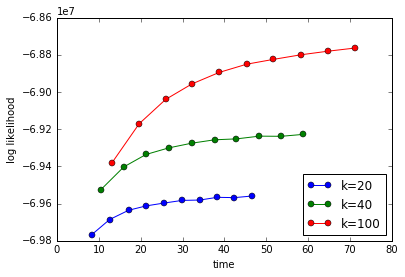

In [36]:
all_k = [20,40,100] # embedding sizes
models = []
for k in all_k:
    model = gensim.models.Word2Vec(sentences, min_count=10, size=k) #your code to create a model here
    models.append(model)
    scores,times = trainMod(model,sentences)
    plt.plot(times,scores,'o-');
    model.save('model-%d'%(k))
    print 'done with',k
plt.legend(['k=%d'%(k) for k in all_k],loc='lower right');
plt.xlabel('time')
plt.ylabel('log likelihood')

**Deliverable 6d** Use the ```most_similar``` function to find similar words to the items in your word_list which are in the vocabulary for your word2vec models. Compare these most similar words with the outputs of the methods tried earlier in the assignment. You may train the word2vec models for longer if you wish, or change any of the parameters. (2 points)

In [37]:
# your code here
for i,model in enumerate(models):
    print "k=",all_k[i]
    for word in word_list:
        if word in model.vocab:
            print word,':',model.most_similar(word),'  \n'
        else:
            continue
    print '\n\n'

k= 20
coffee : [('Taiwan', 0.7958792448043823), ('Wireless', 0.7918726205825806), ('malaria', 0.780410885810852), ('Lanka', 0.7728040218353271), ('Bulgaria', 0.7617757320404053), ('tobacco', 0.7575591206550598), ('vegetables', 0.7532111406326294), ('corn', 0.7470266819000244), ('Herat', 0.74656081199646), ('timber', 0.7395137548446655)]   

play : [('series', 0.814768373966217), ('match', 0.8064485192298889), ('prize', 0.7955950498580933), ('title', 0.7895134687423706), ('publishing', 0.7826794385910034), ('Ashes', 0.7821651101112366), ('tournament', 0.7790948152542114), ('obituary', 0.7631993889808655), ('played', 0.7575876712799072), ('Poirot', 0.7538279294967651)]   

computer : [('device', 0.8768742084503174), ('digital', 0.8441665172576904), ('video', 0.8429996967315674), ('software', 0.835493266582489), ('operating', 0.8238778114318848), ('computers', 0.8059135675430298), ('setting', 0.8002673983573914), ('encoding', 0.7911180257797241), ('graphics', 0.7854411602020264), ('online

(your explanation here)
- As wee see as k increases, the most similar words found makes more and more sense in terms of topic-relativeness, e.g. the word 'Taiwan' ranked No.1 in top 10 most similar words of coffee when k = 20, which dropped to No.8 when k = 40, and out of top 10 when k = 100. This is expected because as you include more and more neighboring, you can get more and more context information.
- In general it works better than LSA and Local Context using SVD

One of the claims about word2vec word embeddings is that they can solve analogy problems, like "man:woman::king:queen"

[This tutorial](http://rare-technologies.com/word2vec-tutorial/) contains example code showing how to use word vectors to try to solve analogies.

**Deliverable 6e** Using the three models trained in the previous deliverable, see if each can solve the analogies man:woman::king:queen and architect:building::painter:painting. Invent two more analogies, and see which of the three models can solve them. You can Google analogies, but you may have to search for a while to find analogies where all four elements are in the vocabulary. You can also retrain the models with a larger vocabulary if you want. (2 points)

### Answer to 6e:
- No apparently it does not solve analogies very well, as you can see below

In [38]:
# your code here
analogies = [ [['man','woman'],['king','queen']],\
      [['architect','building'],['painter','building']],\
      [['science','physics'],['planet','earth']],\
      [['Google','searching'],['computer','programming']] ]

for model in models:
    for a in analogies:
        for aa in a:
            assert aa[0] in model.vocab and aa[1] in model.vocab
    
for i,model in enumerate(models):
    print 'k=',all_k[i]
    for a in analogies:
        print a[0][0]+':'+a[0][1]+'::'+a[1][0]+':?',model.most_similar(positive = a[0],negative=[a[1][0]]),'\n'
    print '\n\n'
        

k= 20
man:woman::king:? [('mistaken', 0.8264424800872803), ('witness', 0.8144932985305786), ('protagonist', 0.7855388522148132), ('creature', 0.779259204864502), ('impression', 0.7787606716156006), ('boy', 0.7532042860984802), ('dinner', 0.7517200112342834), ('good', 0.7417856454849243), ('chance', 0.7412746548652649), ('opportunity', 0.7382452487945557)] 

architect:building::painter:? [('system', 0.7445379495620728), ('monument', 0.725237250328064), ('road', 0.7185670137405396), ('sport', 0.7180393934249878), ('harbour', 0.7033640146255493), ('diocese', 0.6924789547920227), ('central', 0.6686609983444214), ('Chaco', 0.6672202348709106), ('hub', 0.6605966091156006), ('Much', 0.6603871583938599)] 

science:physics::planet:? [('theoretical', 0.8495887517929077), ('mysticism', 0.834299623966217), ('psychology', 0.833200216293335), ('archaeology', 0.788750946521759), ('entities', 0.7664759159088135), ('philosophical', 0.7614248991012573), ('sociology', 0.7585877180099487), ('exploring', 0

# 7. Semi-supervised learning #

Now you will use the word embeddings to try to improve your dependency parser from problem set 5.

You will do this by clustering words according to their embedding.

The code below run the clustering algorithm.

In [39]:
from scipy.cluster.vq import kmeans2

In [40]:
# choose a model to use here
model = models[-1]
word_vectors = model.syn0
# run the clustering algorithm
num_clusters = 200
centroids, labels = kmeans2(word_vectors,num_clusters,iter=200,minit='points')
print centroids, labels

[[-0.19364186  0.16652703 -0.25888926 ...,  0.11673918  0.14041518
  -0.00139467]
 [-0.01532788  0.10720755 -0.09630613 ...,  0.14305694  0.02934444
   0.19374132]
 [ 0.04454674 -0.03849955 -0.22258388 ...,  0.29765904 -0.03476687
  -0.17534447]
 ..., 
 [-0.0088204  -0.17319834 -0.14212954 ...,  0.21196616 -0.15688029
   0.12473287]
 [-0.14776917 -0.13528498  0.11059188 ...,  0.11769114  0.29699549
   0.14274129]
 [-0.09311409 -0.27388129  0.01792685 ...,  0.13583224  0.0908053
   0.10175414]] [ 11  11  11 ..., 192 170   3]


**Deliverable 7a** Modify the code below to show the words in the same cluster as a query word. Find the words in the same cluster as "coffee", "computer", and "red" for at least one of your models, plus any other words of interest. (3 points)

In [41]:
def getWordsInSameCluster(word,model,labels):
    # you will use model.index2word to make this function
    # return a list of words in the same cluster as word
    words2idx = {word:idx for idx,word in enumerate(model.index2word)}
    c = []
    idx = words2idx[word]
    for i in np.where(labels == labels[idx])[0]:
        c.append(model.index2word[i])
    return c

In [42]:
print getWordsInSameCluster('coffee',model,labels),'\n'
print getWordsInSameCluster('computer',model,labels),'\n'
print getWordsInSameCluster('red',model,labels),'\n'
print getWordsInSameCluster('Google',model,labels),'\n'

['animals', 'contain', 'algae', 'almond', 'red', 'almonds', 'trees', 'green', 'diseases', 'wild', 'bacteria', 'meat', 'wine', 'seeds', 'marine', 'toxic', 'sweet', 'cattle', 'dogs', 'milk', 'aromatic', 'lineage', 'domesticated', 'environments', 'sheep', 'horses', 'herbs', 'oils', 'vegetables', 'foods', 'comprise', 'fruits', 'coffee', 'poisonous', 'manure', 'olive', 'corn', 'bread', 'Specific', 'beds', 'dried', 'flour', 'goats', 'brown', 'wool', 'malaria', 'grains', 'honey', 'cows', 'fiber', 'freshwater', 'Algae', 'algal', 'edible', 'shallow', 'potatoes', 'Almonds', 'incense', 'purple', 'gravel', 'mined', 'warmth'] 

['computer', 'design', 'devices', 'device', 'featured', 'video', 'Newton', 'software', 'digital', 'X', 'setting', 'recognition', 'display', 'computers', 'featuring', 'operating', 'user', 'screen', 'users', 'track', 'alongside', 'online', 'hardware', 'Computer', 'format', 'platform', 'audio', 'cards', 'Atari', 'vector', 'Internet', 'graphics', 'library', 'mobile', 'selling', 

## Improving dependency parsing ##

Now incorporate these cluster features into your best performing parser from project 5, based on the dev data. Add a feature for each cluster/tag pair, e.g., C175/N, C189/V, etc. You will then compute the accuracy with training sets of various sizes, comparing the performance of your model with and without the cluster features.

**Deliverable 7b ** Build training sets including the first 50, 100, 200, 500, and 1000 *sentences* (not words). 
Train your tagger on each training set, using your original features, and plot the accuracy on the development set. 
Then retrain you tagger, including the new word cluster features, and plot accuracy on the development set on the same plot. 
Run for at least 10 iterations in each case.

You may want to try larger numbers of clusters to improve performance. 

You can even include the results from multiple clusterings with different numbers of clusters (50, 100, 200, 500, ...), 
using features like C43-50/N (cluster 43 of 50, with tag N), C377-500/V (cluster 377 of 500, with tag V).

You can also use clusters for the features of neighboring words.  (6 points)

In [43]:
# your code here
from os.path import join
import gtparsing
import gtparsing.dependency_parser as depp
import gtparsing.dependency_features as depf
import gtparsing.custom_features
import gtparsing.utilities
from score import accuracy

In [44]:
reload(gtparsing)
reload(depp)
reload(depp)
reload(gtparsing)
reload(gtparsing.custom_features)
reload(gtparsing.dependency_reader)

from gtparsing.custom_features import ContextFeats
num_insts = [50,100,200,500,1000]

dv_accs_cf = []
for n_sents in num_insts:
    dp = depp.DependencyParser(feature_function=ContextFeats())
    dp.read_data("english",n_sents)
    tr_acc, dv_acc = dp.train_perceptron(10) 
    dv_accs_cf.append(dv_acc)

dv_accs_w2v = []
# choose a model to use here: use the model with word embedding size 100
model = models[-1]
word_vectors = model.syn0
# run the clustering algorithm
num_clusters = 500
centroids, labels = kmeans2(word_vectors,num_clusters,iter=200,minit='points')
for n_sents in num_insts:
    words2idx = {word:idx for idx,word in enumerate(model.index2word)}
    dp = depp.DependencyParser(feature_function=gtparsing.custom_features.W2V_ClusterFeats(words2idx, labels))
    dp.read_data("english",n_sents)
    tr_acc ,dv_acc  = dp.train_perceptron(10) 
    dv_accs_w2v.append(dv_acc)
    


gtparsing/../data/deppars
Number of sentences: 50
Number of tokens: 461
Number of words: 278
Number of pos: 34
Number of features: 1647
Epoch 1 Train: 0.416 Dev: 0.490
Epoch 2 Train: 0.755 Dev: 0.580
Epoch 3 Train: 0.861 Dev: 0.608
Epoch 4 Train: 0.898 Dev: 0.621
Epoch 5 Train: 0.937 Dev: 0.626
Epoch 6 Train: 0.961 Dev: 0.629
Epoch 7 Train: 0.976 Dev: 0.633
Epoch 8 Train: 0.963 Dev: 0.636
Epoch 9 Train: 0.991 Dev: 0.636
Epoch 10 Train: 0.998 Dev: 0.639
gtparsing/../data/deppars
Number of sentences: 100
Number of tokens: 975
Number of words: 524
Number of pos: 37
Number of features: 2910
Epoch 1 Train: 0.472 Dev: 0.503
Epoch 2 Train: 0.785 Dev: 0.563
Epoch 3 Train: 0.857 Dev: 0.592
Epoch 4 Train: 0.885 Dev: 0.609
Epoch 5 Train: 0.933 Dev: 0.611
Epoch 6 Train: 0.949 Dev: 0.615
Epoch 7 Train: 0.950 Dev: 0.617
Epoch 8 Train: 0.968 Dev: 0.623
Epoch 9 Train: 0.972 Dev: 0.629
Epoch 10 Train: 0.982 Dev: 0.629
gtparsing/../data/deppars
Number of sentences: 200
Number of tokens: 1873
Number of w

In [45]:
print dv_accs_cf
print dv_accs_w2v

[0.6387466721277902, 0.6291214417366373, 0.6903542903952489, 0.7669465492525087, 0.7775957403235716]
[0.631578947368421, 0.6582019250460782, 0.6770428015564203, 0.7601884087651034, 0.7749334425558059]


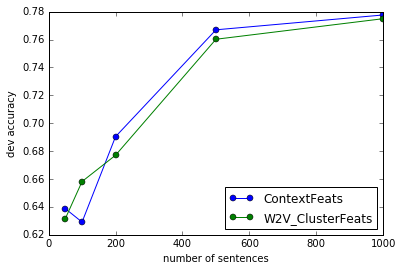

In [46]:
plt.clf()
plt.plot(num_insts, dv_accs_cf,'o-',label = 'ContextFeats')
plt.plot(num_insts,dv_accs_w2v,'o-',label='W2V_ClusterFeats')
plt.legend(loc='lower right')
plt.xlabel('number of sentences')
plt.ylabel('dev accuracy')

In [47]:
# choose a model to use here
model = models[-1]
word_vectors = model.syn0
# run the clustering algorithm
num_clusters = 100
centroids, labels = kmeans2(word_vectors,num_clusters,iter=100,minit='points')
#print centroids, labels

words2idx = {word:idx for idx,word in enumerate(model.index2word)}
dp = depp.DependencyParser(feature_function=gtparsing.custom_features.W2V_ClusterFeats(words2idx, labels))
dp.read_data("english",100)
tr_acc ,dv_acc  = dp.train_perceptron(10) 

gtparsing/../data/deppars
Number of sentences: 100
Number of tokens: 975
Number of words: 524
Number of pos: 37
Number of features: 3507
Epoch 1 Train: 0.481 Dev: 0.514
Epoch 2 Train: 0.789 Dev: 0.609
Epoch 3 Train: 0.885 Dev: 0.635
Epoch 4 Train: 0.920 Dev: 0.643
Epoch 5 Train: 0.944 Dev: 0.647
Epoch 6 Train: 0.961 Dev: 0.652
Epoch 7 Train: 0.966 Dev: 0.656
Epoch 8 Train: 0.953 Dev: 0.660
Epoch 9 Train: 0.973 Dev: 0.662
Epoch 10 Train: 0.979 Dev: 0.665


## 8. Get creative ##

This part is mandatory for 7650 and optional for 4650.

**Deliverable 8 ** K-means clustering is one way to find similarity. This part is opened-ended and requires you to come up with creative solutions of using distributed vectors to improve the results. In addition to implementing your idea, provide explanation of what you did, and why you thought it should work.

The top 3 selected ideas (based mostly on performance, but also on creativity) will get an extra point towards their final score.(5 points)

#### idea: instead of using svd, we can try non-negative matrix factorizatoin
- Non-negative matrix factorization is to factorize full matrix $V$ as $V \approx WH$, where $W$ and $H$ are two low rank matrices with non-negative elements. Since their elements are non-negative, it's more natural to transform them as probability models by normalization. 
- Here I use the module ```NMF``` in library ```sklearn.decomposition``` 
- I don't see significant improvement on word similarity

In [52]:
from sklearn.decomposition import NMF

In [53]:
Dfp

<9993x9993 sparse matrix of type '<type 'numpy.float64'>'
	with 8810954 stored elements in Compressed Sparse Row format>

In [67]:
k = 10
decomp10 = NMF(n_components = k, init='random',random_state=0)
W10 = decomp10.fit_transform(Dfp)
printSimilarWords(W10, word_list, sim_func=lambda word_idx, W10 : -computeEuclidDist(word_idx,W10))

coffee : coffee ordered complete different perfectly turning scary six dramatic apparently 
play : play seeing bands animals they on suits order smack ashley 
crazy : crazy now usually yesterday worked more still i'm will to 
facebook : facebook anime natural vodka rihanna twerk instagram goodbye 42 pizza 
hermana : hermana abuela seleccion durmiendo profe clases primera recien huevo fuego 
computer : computer eating daughter act faced body naked guarantee arm blow 
google : google eff tom apps perfection jackie delicious goo may wow 
science : science red rose modern stretch record lewis stephen passes tax 
math : math mixed childish nonsense ruined dammit complaining quickly bitching screwed 
physics : physics cocaine beyonce blunts spit ran mexican accent teacher wrist 


In [68]:
k = 50
decomp50 = NMF(n_components = k, init='random',random_state=0)
W50 = decomp50.fit_transform(Dfp)
printSimilarWords(W50, word_list, sim_func=lambda word_idx, W50 : -computeEuclidDist(word_idx,W50))

coffee : coffee reading watching packed laundry oil fresh bottles burnt tops 
play : play still her michael star brian curling raise ability rose 
crazy : crazy gives using drug from kinda attention questions nut thinking 
facebook : facebook twitter tv train screen turn hooked posts move roller 
hermana : hermana salir buscar empezar calle llegar durmiendo jamas cabeza pedazo 
computer : computer loose pictures plate switch moon bite body beside money 
google : google holy distance z fck handle exist seems material highly 
science : science runs 2 flying market 1st 5 seconds christmas drawing 
math : math constant ends target #fb exercise fear comfortable drops sets 
physics : physics dragon bottle got outfit spend graduated wearing pass panic 
